In [1]:
import numpy as np 
import pandas as pd
import os
import warnings
import random
import matplotlib.pyplot as plt
import cv2
import pytorch_lightning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
sys.path.append('../')
from utils.LungSet import LungSet
from utils.utils import train_model, evaluate_model, generate_preds, build_model, get_available_devices

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed=2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
BATCH_SIZE = 1024

In [3]:
train_df = pd.read_csv('../data/processed/dataframe_training_selected.csv').sample(frac=1)
test_df = pd.read_csv('../data/processed/dataframe_testing_selected.csv').sample(frac=1)

In [4]:
X_train, y_train = train_df.drop(['label'], axis=1), train_df['label']
X_test, y_test = test_df.drop(['label'], axis=1), test_df['label']

In [5]:
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),    # Randomly flip the image vertically
    transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.001, 0.2)),
    transforms.ToTensor()])  

In [6]:
trainset = LungSet(X_train, y_train, transforms=transformations)
testset = LungSet(X_test, y_test, transforms=transformations)

class_sample_count = list(dict(y_train.value_counts()).values()) # dataset has 10 class-1 samples, 1 class-2 samples, etc.
weights = (1.0 / torch.Tensor(class_sample_count).double())

trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader=DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

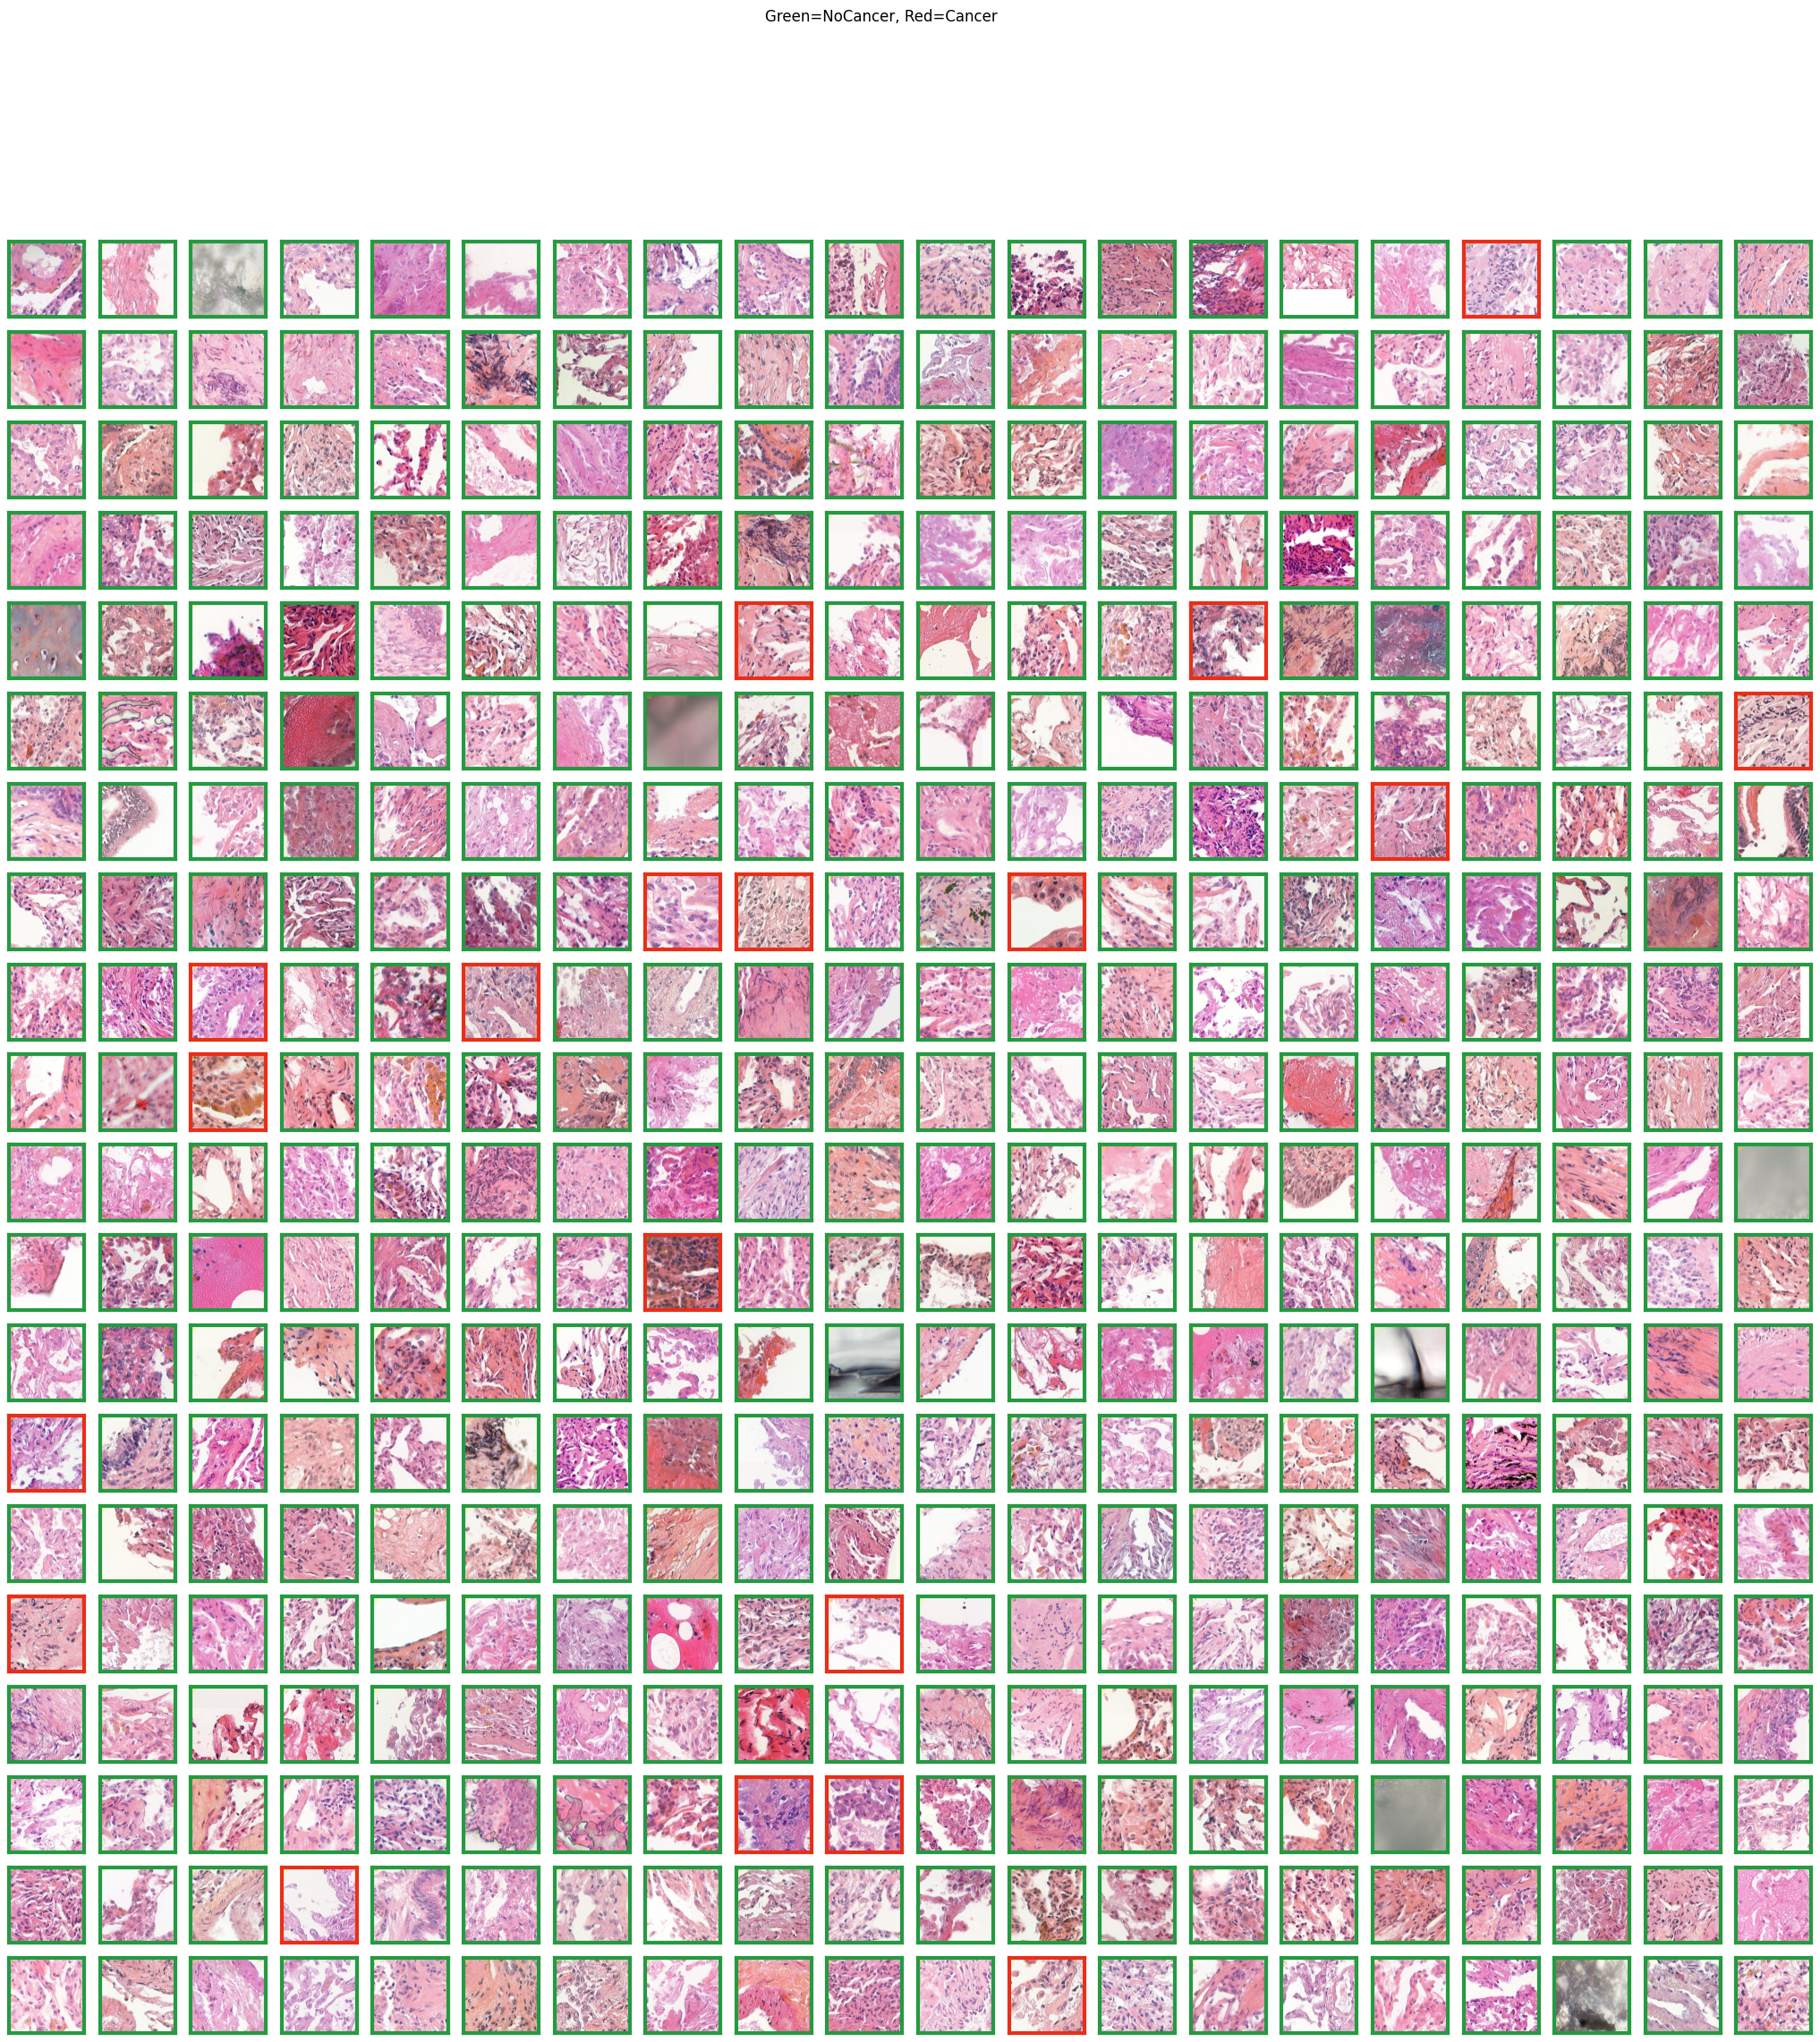

In [104]:
# colors_set = ["#249A41", "#E92E18"]
# border_width = 3
# n_row, n_col = 20, 20

# fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*1.3, n_row*1.3))
# fig.suptitle("Green=NoCancer, Red=Cancer")
# k = 0
# for i in range(n_row):
#     for j in range(n_col): 
#         image, label = X[k], y[k]
#         image = np.transpose(image, [1, 2, 0]) 
#         ax[i, j].imshow(image)
#         ax[i, j].spines[:].set_color(colors_set[label])  # SpinesProxy broadcasts the method call to all spines
#         ax[i, j].spines[:].set_linewidth(border_width)   # SpinesProxy broadcasts the method call to all spines
#         ax[i, j].set_xticklabels([])
#         ax[i, j].set_xticks([])
#         ax[i, j].set_yticklabels([])
#         ax[i, j].set_yticks([])
#         left, bottom, width, height = (7, 7, 32, 32)
#         rectangle = plt.Rectangle((left, bottom), width, height, facecolor="yellow", alpha=0.2)
#         ax[i, j].add_patch(rectangle)
#         k += 1
# fig.show()

In [7]:
# Detect available devices
devices = get_available_devices()
device = devices[0]

model = build_model(device)
if len(devices) > 1:
    model = nn.DataParallel(model, device_ids=[i for i in range(len(devices))])
model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable_params, non_trainable_params

Number of GPUs available: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


(70178, 11176512)

In [12]:
num_epochs = 15

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights.float().to(device), label_smoothing=0.125)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True, min_lr=1e-7)

In [13]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
train_f1s = []
train_f2s = []
test_f1s = []
test_f2s = []

model.eval()
epoch_loss, epoch_acc, precision, recall, f1, f2 = evaluate_model(model, trainloader, criterion, device)
test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
train_losses.append(epoch_loss)
train_accuracies.append(epoch_acc)
test_losses.append(test_loss)
test_accuracies.append(test_acc)
train_f1s.append(f1)
train_f2s.append(f2)
test_f1s.append(test_f1)
test_f2s.append(test_f2)
print(f"Epoch [{0}/{num_epochs}], Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}% -- Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}%")
print(f"Train Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
print(f"Test  Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")

for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_acc, precision, recall, f1, f2  = train_model(model, trainloader, criterion, optimizer, device)
    model.eval()
    test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
    schedular.step(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}% -- Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}%")
    print(f"Train Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
    print(f"Test  Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    train_f1s.append(f1)
    train_f2s.append(f2)
    test_f1s.append(test_f1)
    test_f2s.append(test_f2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [20:33<00:00, 77.12s/it]


Epoch [0/15], Loss=0.9712, Acc=56.917% -- Test Loss=0.8361, Test Acc=51.853%
Train Precision: 0.858, Recall: 0.569, F1: 0.678, F2: 0.605
Test  Precision: 0.691, Recall: 0.519, F1: 0.587, F2: 0.542


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [13:52<00:00, 52.06s/it]


Epoch [1/15], Loss=0.8237, Acc=66.379% -- Test Loss=0.5846, Test Acc=69.080%
Train Precision: 0.944, Recall: 0.664, F1: 0.749, F2: 0.678
Test  Precision: 0.900, Recall: 0.691, F1: 0.736, F2: 0.690


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:47<00:00, 14.21s/it]


Epoch [2/15], Loss=0.8016, Acc=61.039% -- Test Loss=0.5838, Test Acc=74.057%
Train Precision: 0.945, Recall: 0.610, F1: 0.706, F2: 0.625
Test  Precision: 0.906, Recall: 0.741, F1: 0.778, F2: 0.741


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:45<00:00, 14.11s/it]


Epoch [3/15], Loss=0.7986, Acc=61.761% -- Test Loss=0.5824, Test Acc=81.437%
Train Precision: 0.945, Recall: 0.618, F1: 0.712, F2: 0.632
Test  Precision: 0.918, Recall: 0.814, F1: 0.839, F2: 0.815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:46<00:00, 14.17s/it]


Epoch [4/15], Loss=0.7987, Acc=63.668% -- Test Loss=0.5818, Test Acc=87.000%
Train Precision: 0.946, Recall: 0.637, F1: 0.727, F2: 0.651
Test  Precision: 0.931, Recall: 0.870, F1: 0.885, F2: 0.871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:40<00:00, 13.79s/it]


Epoch [5/15], Loss=0.7964, Acc=65.966% -- Test Loss=0.5815, Test Acc=89.453%
Train Precision: 0.946, Recall: 0.660, F1: 0.745, F2: 0.673
Test  Precision: 0.939, Recall: 0.895, F1: 0.905, F2: 0.895


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:46<00:00, 14.18s/it]


Epoch [6/15], Loss=0.7965, Acc=69.982% -- Test Loss=0.5812, Test Acc=92.048%
Train Precision: 0.947, Recall: 0.700, F1: 0.776, F2: 0.712
Test  Precision: 0.948, Recall: 0.920, F1: 0.927, F2: 0.921


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:46<00:00, 14.14s/it]


Epoch [7/15], Loss=0.7957, Acc=71.836% -- Test Loss=0.5813, Test Acc=91.978%
Train Precision: 0.948, Recall: 0.718, F1: 0.790, F2: 0.730
Test  Precision: 0.948, Recall: 0.920, F1: 0.926, F2: 0.920


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:55<00:00, 14.71s/it]


Epoch [8/15], Loss=0.7948, Acc=76.144% -- Test Loss=0.5810, Test Acc=93.558%
Train Precision: 0.949, Recall: 0.761, F1: 0.822, F2: 0.772
Test  Precision: 0.955, Recall: 0.936, F1: 0.940, F2: 0.936


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:45<00:00, 14.12s/it]


Epoch [9/15], Loss=0.7948, Acc=80.019% -- Test Loss=0.5811, Test Acc=94.662%
Train Precision: 0.952, Recall: 0.800, F1: 0.849, F2: 0.808
Test  Precision: 0.961, Recall: 0.947, F1: 0.950, F2: 0.947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:34<00:00, 13.41s/it]


Epoch [10/15], Loss=0.7951, Acc=82.496% -- Test Loss=0.5812, Test Acc=92.549%
Train Precision: 0.953, Recall: 0.825, F1: 0.866, F2: 0.832
Test  Precision: 0.951, Recall: 0.925, F1: 0.931, F2: 0.926


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:41<00:00, 13.84s/it]


Epoch [11/15], Loss=0.7946, Acc=87.738% -- Test Loss=0.5809, Test Acc=96.968%
Train Precision: 0.958, Recall: 0.877, F1: 0.903, F2: 0.882
Test  Precision: 0.975, Recall: 0.970, F1: 0.971, F2: 0.970


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:36<00:00, 13.53s/it]


Epoch [12/15], Loss=0.7943, Acc=90.204% -- Test Loss=0.5810, Test Acc=94.335%
Train Precision: 0.961, Recall: 0.902, F1: 0.921, F2: 0.905
Test  Precision: 0.959, Recall: 0.943, F1: 0.947, F2: 0.944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:41<00:00, 13.84s/it]


Epoch [13/15], Loss=0.7950, Acc=92.815% -- Test Loss=0.5809, Test Acc=97.302%
Train Precision: 0.966, Recall: 0.928, F1: 0.940, F2: 0.930
Test  Precision: 0.977, Recall: 0.973, F1: 0.974, F2: 0.973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:37<00:00, 17.31s/it]


Epoch [14/15], Loss=0.7943, Acc=93.536% -- Test Loss=0.5812, Test Acc=93.320%
Train Precision: 0.968, Recall: 0.935, F1: 0.945, F2: 0.937
Test  Precision: 0.954, Recall: 0.933, F1: 0.938, F2: 0.933


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [05:15<00:00, 19.74s/it]

Epoch [15/15], Loss=0.7938, Acc=95.225% -- Test Loss=0.5810, Test Acc=94.740%
Train Precision: 0.973, Recall: 0.952, F1: 0.958, F2: 0.953
Test  Precision: 0.961, Recall: 0.947, F1: 0.951, F2: 0.948


In [16]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_acc, precision, recall, f1, f2  = train_model(model, trainloader, criterion, optimizer, device)
    model.eval()
    test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
    schedular.step(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}% -- Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}%")
    print(f"Train Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
    print(f"Test  Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    train_f1s.append(f1)
    train_f2s.append(f2)
    test_f1s.append(test_f1)
    test_f2s.append(test_f2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:26<00:00, 16.68s/it]


Epoch [1/15], Loss=0.7942, Acc=93.395% -- Test Loss=0.5812, Test Acc=93.660%
Train Precision: 0.967, Recall: 0.934, F1: 0.944, F2: 0.935
Test  Precision: 0.956, Recall: 0.937, F1: 0.941, F2: 0.937


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:28<00:00, 13.06s/it]


Epoch [2/15], Loss=0.7935, Acc=95.263% -- Test Loss=0.5808, Test Acc=98.587%
Train Precision: 0.973, Recall: 0.953, F1: 0.958, F2: 0.953
Test  Precision: 0.987, Recall: 0.986, F1: 0.986, F2: 0.986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:29<00:00, 13.11s/it]


Epoch [3/15], Loss=0.7938, Acc=95.984% -- Test Loss=0.5807, Test Acc=98.176%
Train Precision: 0.975, Recall: 0.960, F1: 0.964, F2: 0.960
Test  Precision: 0.984, Recall: 0.982, F1: 0.982, F2: 0.982


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:33<00:00, 13.35s/it]


Epoch [4/15], Loss=0.7938, Acc=96.289% -- Test Loss=0.5810, Test Acc=96.416%
Train Precision: 0.977, Recall: 0.963, F1: 0.967, F2: 0.963
Test  Precision: 0.971, Recall: 0.964, F1: 0.966, F2: 0.964


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:20<00:00, 12.55s/it]


Epoch [5/15], Loss=0.7944, Acc=96.716% -- Test Loss=0.5807, Test Acc=97.720%
Train Precision: 0.978, Recall: 0.967, F1: 0.970, F2: 0.968
Test  Precision: 0.980, Recall: 0.977, F1: 0.978, F2: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:20<00:00, 12.51s/it]


Epoch [6/15], Loss=0.7945, Acc=96.739% -- Test Loss=0.5808, Test Acc=96.878%
Train Precision: 0.978, Recall: 0.967, F1: 0.970, F2: 0.968
Test  Precision: 0.974, Recall: 0.969, F1: 0.970, F2: 0.969


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:22<00:00, 12.63s/it]


Epoch [7/15], Loss=0.7937, Acc=97.125% -- Test Loss=0.5807, Test Acc=97.379%
Train Precision: 0.980, Recall: 0.971, F1: 0.974, F2: 0.972
Test  Precision: 0.978, Recall: 0.974, F1: 0.975, F2: 0.974


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:18<00:00, 12.43s/it]


Epoch [8/15], Loss=0.7931, Acc=96.796% -- Test Loss=0.5806, Test Acc=98.285%
Train Precision: 0.979, Recall: 0.968, F1: 0.971, F2: 0.968
Test  Precision: 0.985, Recall: 0.983, F1: 0.983, F2: 0.983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:18<00:00, 12.39s/it]


Epoch [9/15], Loss=0.7931, Acc=97.218% -- Test Loss=0.5808, Test Acc=98.632%
Train Precision: 0.981, Recall: 0.972, F1: 0.974, F2: 0.972
Test  Precision: 0.987, Recall: 0.986, F1: 0.987, F2: 0.986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:20<00:00, 12.56s/it]


Epoch [10/15], Loss=0.7937, Acc=97.035% -- Test Loss=0.5808, Test Acc=96.191%
Train Precision: 0.980, Recall: 0.970, F1: 0.973, F2: 0.971
Test  Precision: 0.970, Recall: 0.962, F1: 0.964, F2: 0.962


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:22<00:00, 12.67s/it]


Epoch [11/15], Loss=0.7932, Acc=97.512% -- Test Loss=0.5808, Test Acc=97.579%
Train Precision: 0.982, Recall: 0.975, F1: 0.977, F2: 0.975
Test  Precision: 0.979, Recall: 0.976, F1: 0.977, F2: 0.976


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:22<00:00, 12.65s/it]


Epoch [12/15], Loss=0.7931, Acc=97.570% -- Test Loss=0.5807, Test Acc=98.202%
Train Precision: 0.982, Recall: 0.976, F1: 0.977, F2: 0.976
Test  Precision: 0.984, Recall: 0.982, F1: 0.982, F2: 0.982


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:16<00:00, 12.27s/it]


Epoch [13/15], Loss=0.7931, Acc=97.700% -- Test Loss=0.5807, Test Acc=98.054%
Train Precision: 0.983, Recall: 0.977, F1: 0.979, F2: 0.977
Test  Precision: 0.983, Recall: 0.981, F1: 0.981, F2: 0.981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:24<00:00, 12.81s/it]


Epoch [14/15], Loss=0.7935, Acc=97.805% -- Test Loss=0.5807, Test Acc=97.322%
Train Precision: 0.984, Recall: 0.978, F1: 0.980, F2: 0.978
Test  Precision: 0.977, Recall: 0.973, F1: 0.974, F2: 0.973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:18<00:00, 12.41s/it]

Epoch [15/15], Loss=0.7932, Acc=97.657% -- Test Loss=0.5806, Test Acc=98.381%
Train Precision: 0.983, Recall: 0.977, F1: 0.978, F2: 0.977
Test  Precision: 0.985, Recall: 0.984, F1: 0.984, F2: 0.984


In [18]:
torch.save(model.state_dict(), '../models/digilut_model_fine_tuned_with_ozenciga.pt')
torch.save(optimizer.state_dict(), '../models/digilut_optimizer_fine_tuned_with_ozenciga.pt')

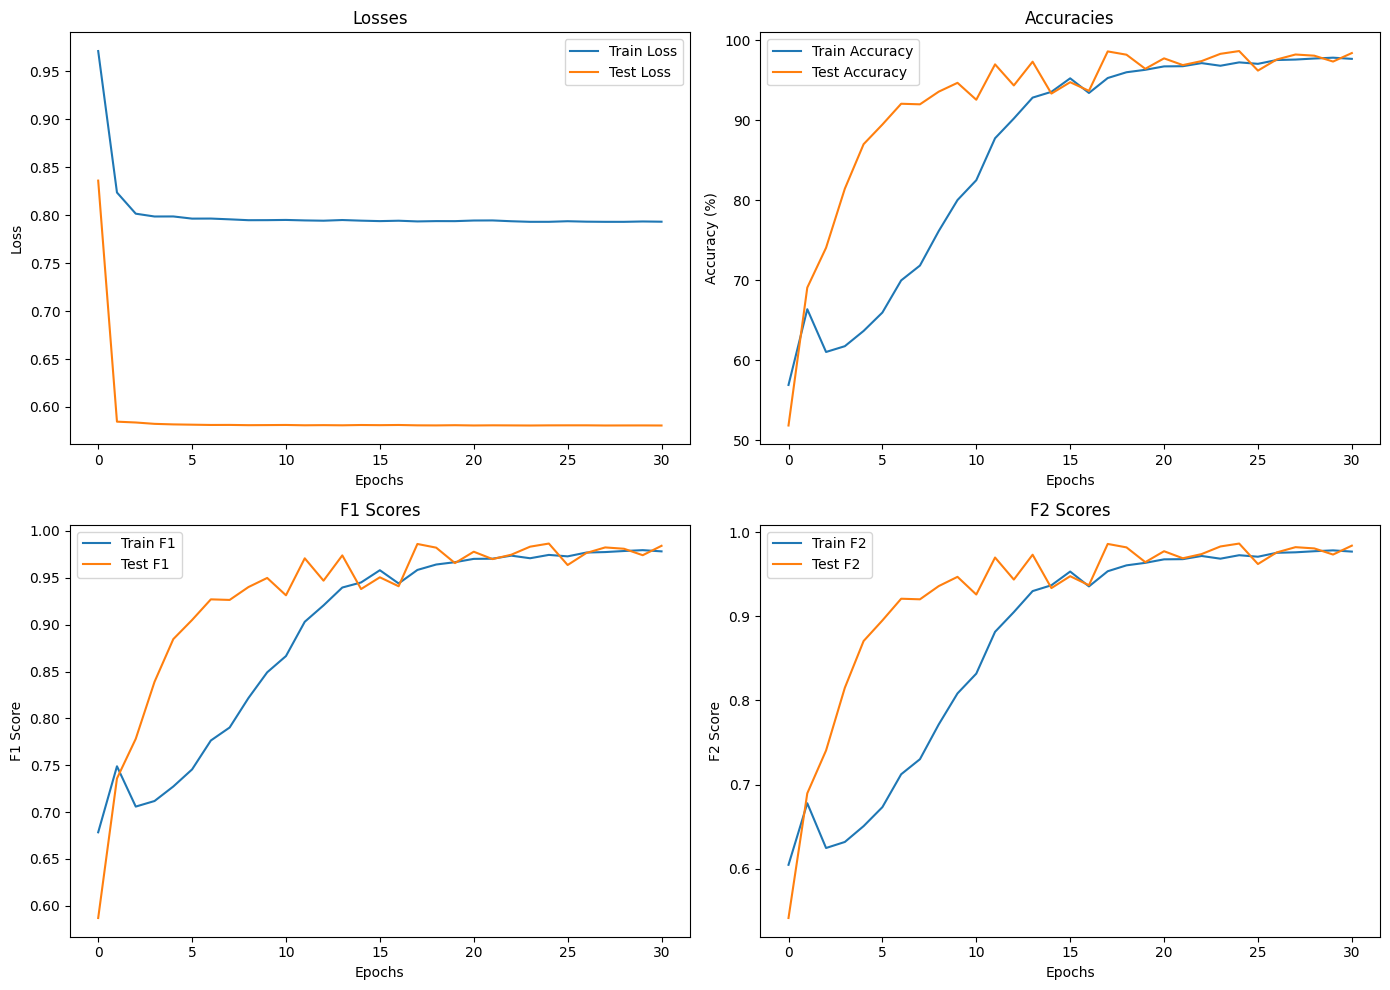

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot for Losses
axes[0, 0].plot(train_losses, label='Train Loss')
axes[0, 0].plot(test_losses, label='Test Loss')
axes[0, 0].set_title('Losses')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot for Accuracies
axes[0, 1].plot(train_accuracies, label='Train Accuracy')
axes[0, 1].plot(test_accuracies, label='Test Accuracy')
axes[0, 1].set_title('Accuracies')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()

# Plot for F1 Scores
axes[1, 0].plot(train_f1s, label='Train F1')
axes[1, 0].plot(test_f1s, label='Test F1')
axes[1, 0].set_title('F1 Scores')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()

# Plot for F2 Scores
axes[1, 1].plot(train_f2s, label='Train F2')
axes[1, 1].plot(test_f2s, label='Test F2')
axes[1, 1].set_title('F2 Scores')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('F2 Score')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [20]:
model.eval()
epoch_loss, epoch_acc, precision, recall, f1, f2 = evaluate_model(model, trainloader, criterion, device)
test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
print(f"Train Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}%, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
print(f"Test  Loss={test_loss:.4f}, Acc={test_acc:.3f}% Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:19<00:00, 12.45s/it]

Train Loss=0.7926, Acc=99.376%, Precision: 0.994, Recall: 0.994, F1: 0.994, F2: 0.994
Test  Loss=0.5807, Acc=98.401% Precision: 0.986, Recall: 0.984, F1: 0.984, F2: 0.984


In [21]:
y_test, y_test_preds = generate_preds(model, testloader, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:25<00:00, 12.81s/it]


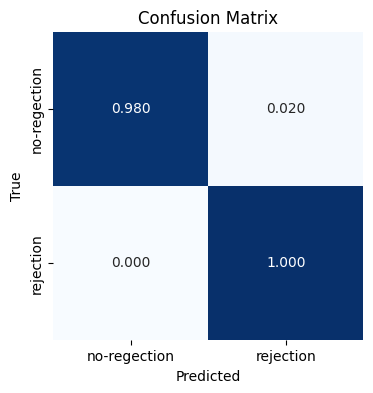

In [22]:
from sklearn.metrics import *
import seaborn as sns

cm = confusion_matrix(y_test, y_test_preds, normalize='true')
class_names = ['no-regection', 'rejection']
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', cbar=False, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.title('Confusion Matrix')
plt.show()